In [1]:
#import gpboost as gpb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
plt.style.use('ggplot')
#Actualización de este notebook: Sep 18, 2023

# Clasificación de Series de Tiempo usando Topología...

En este simple notebook vamos a introducir una manera sencilla de estudiar series de tiempo desde un punto de vista no usual, pero que sin embargo, ha amumentado su interés en los últimos años. La intensión principal es observar como algunas técnicas de topología, caos y fractalidad pueden ser usadas para estudiar series de tiempo en las cuales algunos comportamientos y/o dinámicas pueden estar escondidos en la dinámica propia de las series.

Para este simple ejercicio vamos a usar un par de librerías. No son esenciales ni impedimentos para continuar, pero en esta ocasión van a dinamizar y acelerar el proceso. La idea es que lo que hagamos acá puede ser usado para cualquier serie de tiempo en cualquier ámbito o área de estudio. Vamos a usar dos librerías principales adicional a las básicas de Python (Todo está en Python!):
- Necesitamos una base de datos: vamos a usar una en red, por ejemplo aquí usamos http://timeseriesclassification.com/dataset.php y una librería que han creado para cargar y estudiar series de tiempo. Vamos a usar esta librería `aeon` desarrolla por el equipo de la paǵina. Puede instalarla rápidamente en google colab haciendo: `pip install aeon` o `pip3 install aeon` (dependiendo del sistema).
- Necesitaos un código para validar y reproducir el algoritmo de *Horizontal Visibility Graph Analysis*. En realidad el código es extremadamente simple pero tenemos algunas opciones para usar algunos ya existentes. O sea vamos a usar `visibility-graph 0.5.1` que se puede instalar rápidamente usando `pip install visibility-graph` o `pip3 install visibility-graph` (dependiendo del sistema).

Eso es todo, con esto tenemos todo listo en el sistema para funcionar. Vamos a ello.

In [2]:
!pip3 install aeon --break-system-packages
!pip3 install visibility-graph --break-system-packages

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


### Los datos aqui son tomados de https://astrostatistics.psu.edu/datasets/galspec.html.
### Dataset
Here we illustrate some of the challenges of galaxy spectral analysis with data from the KPNO (Kitt Peak National Observatory) International Spectroscopic Survey (KISS) which has catalogued over 2000 emission-line galaxies. We show here low-resolution spectra from the 8-meter-class Hobby-Eberly Telescope in Texas. The datasets, figures and numerical results below are obtained from the following paper:
Spectroscopy of KISS emission-line galaxy candidates. II Hobby-Eberly Telescope observations, Caryl Gronwall, Anna Jangren, John J. Salzer, Kessica K. Werk, Robin Ciardullo. Astronomical Journal, 128, 644-661 (2004)
The first figure shows two spectra from Seyfert 2 (low redshift) and starburst galaxies. (high redshift) 

In [3]:
data11=pd.read_csv("f1329_3262.dat.txt",delimiter="\s+",names=["lambda","Flux"])
data21=pd.read_csv("f1308_5325.dat.txt",delimiter="\s+",names=["lambda","Flux"])

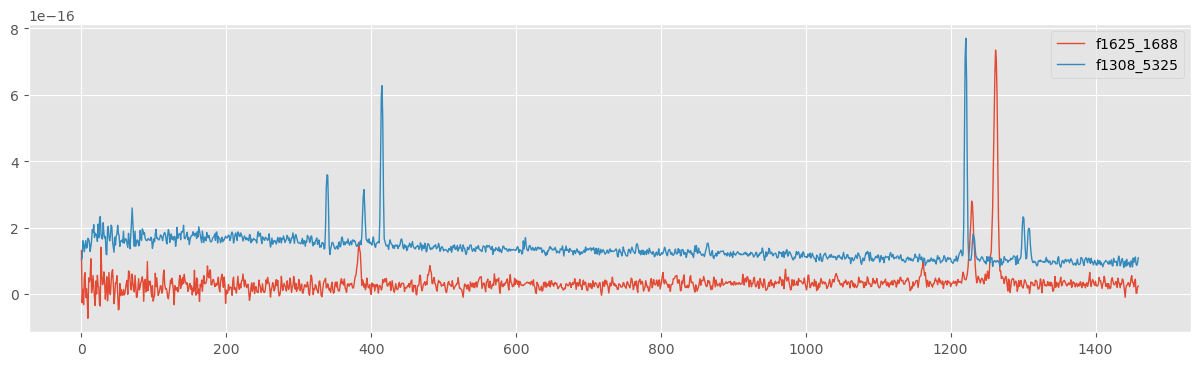

In [4]:
plt.figure(figsize=(15,4))
data11["Flux"].plot(label="f1625_1688",lw=1,linestyle="-")
data21["Flux"].plot(label="f1308_5325",lw=1,linestyle="-")
plt.legend()

Aquí ilustramos algunos de los retos del análisis espectral de galaxias con datos del Estudio Espectroscópico Internacional (KISS) del Observatorio Nacional de Kitt Peak (KPNO), que ha catalogado más de 2.000 galaxias de líneas de emisión. Mostramos aquí espectros de baja resolución procedentes del telescopio Hobby-Eberly de 8 metros de Texas. Los conjuntos de datos, figuras y resultados numéricos que aparecen a continuación se han obtenido del siguiente artículo: "Spectroscopy of KISS emission-line galaxy candidates. II Hobby-Eberly Telescope observations, Caryl Gronwall, Anna Jangren, John J. Salzer, Kessica K. Werk, Robin Ciardullo. Astronomical Journal, 128, 644-661 (2004)"


En estos espectros: La figura muestra dos espectros:
- *f1625_1688* (z=0.4100): de galaxias tipo Seyfert 2.  Puede apreciarse el desplazamiento progresivo de los espectros hacia el rojo (el desplazamiento fraccional es el corrimiento al rojo z).  Las principales líneas de emisión son el doblete [OIII] de átomos de oxígeno doblemente ionizados (hacia la derecha, siempre con una relación de intensidad 1:3), y la línea H-beta con longitud de onda en reposo de 4861 Angstroms.

- *f1308_5325* (z=0.0356): A continuación se muestran también un espectro de galaxia con brotes estelares a desplazamientos al rojo más bajos. Las líneas destacadas (empezando por el rojo) son: el doblete de nitrógeno ionizado prohibido [NII] en 6583 y 6548 A; la fuerte línea H-alfa de hidrógeno en 6562 A, el doblete de oxígeno ionizado prohibido en [Oiii] 5007 y 4958 A; H-beta en 4861 A.

In [5]:
from visibility_graph import visibility_graph
import networkx as nx
import sys
import statsmodels.api as sm

In [6]:
c11 = visibility_graph(data11["Flux"])
nx.write_edgelist(c11, "c11_vis_results")
c21 = visibility_graph(data21["Flux"])
nx.write_edgelist(c21, "c21_vis_results")

In [7]:
def removeceros(lista1, lista2):
    while 0 in lista1:
        lista2.pop(lista1.index(0))
        lista1.remove(0)
    return lista1, lista2

Vamos a crear una función que construya la distribución acumulativa de nodos para poder extraer features o características que permitan clasificar, describir y categorizar algunas propiedades del grafo.

In [8]:
def get_alpha(data,li_fit,ls_fit,xlimi,xlims,color,name):
    G = nx.read_edgelist(data, nodetype=int)
    # Calculate degree distribution
    degree_sequence = G.degree()#[G.degree(node) for node in G.nodes()]
    degree_count = nx.degree_histogram(G)
    
    degrees = list(range(len(degree_count)))
    degree_count, degrees =removeceros(degree_count,degrees)
    
    # Normalize the degree distribution
    degree_distribution = [count / float(sum(degree_count)) for count in degree_count]
    # Calcule alpha
    x0,y0=np.array(np.log10(degrees)),np.array(np.log10(degree_distribution))
    x0,y0=x0[np.isfinite(x0)],y0[np.isfinite(x0)]
    x,y=x0[(x0>=li_fit)&(x0<=ls_fit)],y0[(x0>=li_fit)&(x0<=ls_fit)]
    x = sm.add_constant(x)
    model = sm.OLS(y, x).fit()
    predictions = model.predict(x) 
    print_model = model.summary()

    # Plot degree distribution
    plt.figure(figsize=(6,4))
    plt.plot(x0,y0,color=color,linewidth=0,marker="P",markersize=5,label="data")
    a=np.linspace(li_fit,ls_fit,10)
    plt.plot(a,(a)*(model.params[1])+model.params[0]*1.,color="k",lw=3,label=r"fit ($\alpha_0={}$)".format(-np.round(model.params[1],2)))
    plt.xlabel(r'$\log_{10}(k)$ (Degree)'); plt.ylabel(r'$\log_{10} P(k)$'); plt.title('Degree Distribution {}'.format(name)); plt.legend(); plt.xlim(xlimi,xlims)
    plt.legend(title=r"$P(k)\sim x^{-\alpha_0}$"); plt.grid(alpha=0.5)
    #plt.savefig(data+".pdf",dpi=400,bbox_inches='tight')
    plt.show()
    return x0,y0,x,y,li_fit,ls_fit,xlimi,xlims,np.round(model.params[0],2),np.round(model.params[1],2), G

/usr/lib/python3/dist-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


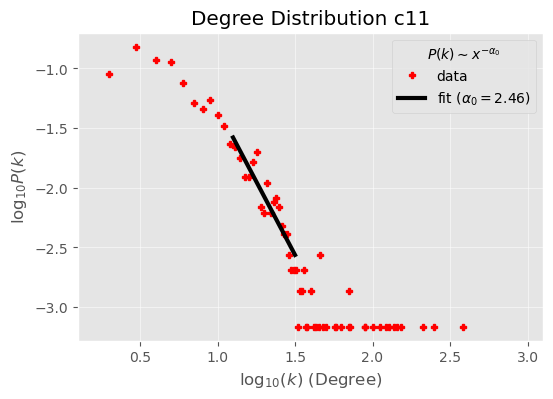

In [9]:
c11_a=get_alpha("c11_vis_results",1.1,1.5,0.1,3.1,"red","c11")

/usr/lib/python3/dist-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


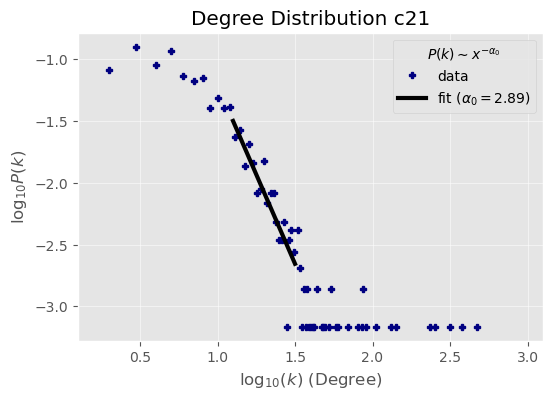

In [10]:
c21_a=get_alpha("c21_vis_results",1.1,1.5,0.1,3.1,"navy","c21")

In [11]:
from scipy.stats import entropy

def calculate_metrics1(g):
    G = nx.read_edgelist(g, nodetype=int)
    #G = nx.Graph(G)
    # Calcula las medidas de centralidad y otras métricas
    betweenness_centrality = np.mean(list(nx.betweenness_centrality(G).values()))
    return betweenness_centrality

def calculate_metrics2(g):
    G = nx.read_edgelist(g, nodetype=int)
    #G = nx.Graph(G)
    # Calcula las medidas de centralidad y otras métricas
    closeness_centrality = np.mean(list(nx.closeness_centrality(G).values()))
    return closeness_centrality

def calculate_metrics3(g):
    G = nx.read_edgelist(g, nodetype=int)
    #G = nx.Graph(G)
    # Calcula las medidas de centralidad y otras métricas
    eigenvector_centrality = np.mean(list(nx.eigenvector_centrality(G).values()))
    return eigenvector_centrality

def calculate_metrics4(g):
    G = nx.read_edgelist(g, nodetype=int)
    #G = nx.Graph(G)
    # Calcula las medidas de centralidad y otras métricas
    clustering_coefficient = np.mean(list(nx.clustering(G).values()))
    return clustering_coefficient

def calculate_metrics5(g):
    G = nx.read_edgelist(g, nodetype=int)
    #G = nx.Graph(G)
    # Calcula las medidas de centralidad y otras métricas
    assortativity_coefficient = nx.degree_assortativity_coefficient(G)
    return assortativity_coefficient

def higuchi_fd(data, k_max):
    n = len(data)
    L = np.arange(1, k_max + 1)
    x = np.empty((k_max,))
    y = np.empty((k_max,))
    for k in L:
        Lk = np.zeros((k,))
        for m in range(k):
            N = int(np.floor((n - m - 1) / k))
            for i in range(1, N):
                Lk[k - 1] += abs(data[m + i * k] - data[m + i * k - k])
            Lk[k - 1] = Lk[k - 1] * (n - 1) / (k * N)
        x[k - 1] = np.log(1.0 / k)
        y[k - 1] = np.log(np.mean(Lk))
    
    # Fit a linear regression line to (x, y) and get the slope (HFD)
    slope, _ = np.polyfit(x, y, 1)
    
    return slope

Adicionalmente podemos calcular algunos parámetros en particular observe los parámetros de entropia y Higuchi Fractal Dimension.

- *La entropía de Shannon*, a menudo referida simplemente como entropía, es una medida fundamental en teoría de la información y teoría de la probabilidad que se utiliza para cuantificar la incertidumbre o el grado de sorpresa asociado con una variable aleatoria. Fue desarrollada por el matemático y criptógrafo estadounidense Claude Shannon en la década de 1940 y es ampliamente utilizada en campos como la teoría de la información, la estadística, la teoría de la comunicación y la codificación de datos.

- *La dimensión fractal de Higuchi*, a veces llamada dimensión fractal de Higuchi-Karpinski, es una medida utilizada en análisis de series temporales y procesamiento de señales para caracterizar la rugosidad o complejidad de una serie temporal. Fue desarrollada por el matemático japonés Takashi Higuchi en 1988. La dimensión fractal de Higuchi se utiliza principalmente para analizar series temporales que representan datos secuenciales, como series de tiempo financieras, electroencefalogramas (EEG) o cualquier conjunto de datos que muestre una estructura secuencial. La idea detrás de esta medida es determinar cuán "fractal" o cuán irregular es una serie temporal en función de su comportamiento a diferentes escalas temporales.

- *El coeficiente de assortativity* (coeficiente de asortatividad) es una medida utilizada en la teoría de redes para cuantificar la tendencia de los nodos en una red a conectarse preferentemente con otros nodos que tienen características similares. En otras palabras, mide la preferencia de los nodos para asociarse con nodos que tienen un grado (número de conexiones) similar.

- *La betweenness centrality (centralidad de intermediación)* es una medida utilizada en la teoría de redes para evaluar la importancia relativa de un nodo dentro de una red. Esta medida se basa en la idea de que algunos nodos actúan como intermediarios o puentes cruciales en una red al conectar diferentes partes de la misma. En otras palabras, la betweenness centrality cuantifica cuántas veces un nodo en particular se encuentra en el camino más corto entre pares de otros nodos en la red.

- *La closeness centrality (centralidad de cercanía)* es una medida utilizada en la teoría de redes para evaluar la importancia relativa de un nodo dentro de una red en función de su distancia promedio a todos los demás nodos. Esta medida se basa en la idea de que los nodos que están más cerca de otros nodos en términos de distancia geodésica son más "cercanos" en términos de accesibilidad y, por lo tanto, se consideran más centrales en la red.

In [12]:
#Para los espectros
print("betweenness_centrality:",calculate_metrics1("c11_vis_results"))
print("closeness_centrality:",calculate_metrics2("c11_vis_results"))
print("clustering:",calculate_metrics4("c11_vis_results"))
print("degree_assortativity_coefficient:",calculate_metrics5("c11_vis_results"))
print("entropy:",entropy((data11["Flux"].values-data11["Flux"].values.min())/(data11["Flux"].values.max()-data11["Flux"].values.min()),base=10))
print("higuchi_fd:",higuchi_fd(data11["Flux"],10))

betweenness_centrality: 0.0018362620292105697
closeness_centrality: 0.27957302751753055
clustering: 0.7500806014727827
degree_assortativity_coefficient: -0.07552562187733382
entropy: 3.141783628173311
higuchi_fd: 0.7658035056826396


In [13]:
print("betweenness_centrality:",calculate_metrics1("c21_vis_results"))
print("closeness_centrality:",calculate_metrics2("c21_vis_results"))
print("clustering:",calculate_metrics4("c21_vis_results"))
print("degree_assortativity_coefficient:",calculate_metrics5("c21_vis_results"))
print("entropy:",entropy((data21["Flux"].values-data21["Flux"].values.min())/(data21["Flux"].values.max()-data21["Flux"].values.min()),base=10))
print("higuchi_fd:",higuchi_fd(data21["Flux"],10))

betweenness_centrality: 0.001598496143977246
closeness_centrality: 0.3085455094753268
clustering: 0.7587385075393244
degree_assortativity_coefficient: -0.1318394178197806
entropy: 3.0692976203189115
higuchi_fd: 0.7531161490352776
